In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Bank marketing : loading data

In [7]:
!ls

CHANGELOG.md
Dockerfile
Dockerfile_gpu
LICENSE
Makefile
README.md
bohb_tuner.ipynb
conv1d-generic-bnp-cardif.ipynb
conv1d-generic-census-income-tuner.ipynb
conv1d-generic-census-income.ipynb
conv1d-generic-credit.ipynb
conv1d-generic-forest-cover.ipynb
conv1d-generic-house-prices-tuner.ipynb
conv1d-generic-houses-prices.ipynb
conv1d-generic-wine-regressor.ipynb
data
kaggle_submit.csv
model.png
release-0.1.1
release-script
renovate.json
test_dir
xplainet


<IPython.core.display.Javascript object>

In [8]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
dataset_name = "train_bench"
# out_zip = Path(os.getcwd().rsplit("/", 1)[0] + "/data/bank-additional.zip")
out = Path(os.getcwd()) / "data/give-me-some-credit/" / (dataset_name + ".csv")

# download(url, out_zip)
# with ZipFile(out_zip, "r") as zipObj:
#     zipObj.extractall("/data")

target = "SeriousDlqin2yrs"
to_remove = ["Set", "Unamed", "NumberOfTimes90DaysLate"]
train = pd.read_csv(out, low_memory=False)

<IPython.core.display.Javascript object>

In [9]:
train.columns

Index(['Unamed', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents', 'Set'],
      dtype='object')

<IPython.core.display.Javascript object>

In [10]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

<IPython.core.display.Javascript object>

In [11]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [12]:
input_train, params = preproc_dataset(train.loc[train_indices], target, to_remove)
params

{'constant_cols': [],
 'bool_cols': [],
 'num_cols': ['MonthlyIncome',
  'DebtRatio',
  'RevolvingUtilizationOfUnsecuredLines'],
 'cat_cols': ['age',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfDependents',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTime60-89DaysPastDueNotWorse'],
 'num_encoder': [FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=-1439.9006063988938,
                                                                 strategy='constant')),
                                                  ('scaler',
                                                   StandardScaler())]))]),
  FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=-203.48093406512314,
                           

<IPython.core.display.Javascript object>

In [13]:
len(train_indices)

120000

<IPython.core.display.Javascript object>

In [14]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, to_remove, params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, to_remove, params)

<IPython.core.display.Javascript object>

In [15]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [16]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [17]:
params

{'constant_cols': [],
 'bool_cols': [],
 'num_cols': ['MonthlyIncome',
  'DebtRatio',
  'RevolvingUtilizationOfUnsecuredLines'],
 'cat_cols': ['age',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfDependents',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTime60-89DaysPastDueNotWorse'],
 'num_encoder': [FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=-1439.9006063988938,
                                                                 strategy='constant')),
                                                  ('scaler',
                                                   StandardScaler())]))]),
  FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=-203.48093406512314,
                           

<IPython.core.display.Javascript object>

In [18]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    activation_num_first_layer=None,  # "tanh",
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are

<IPython.core.display.Javascript object>

In [19]:
model.get_layer("output")._build_input_shape

TensorShape([None, 48])

<IPython.core.display.Javascript object>

In [20]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_num (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_cat (InputLayer)          [(None, 6)]          0                                            
__________________________________________________________________________________________________
reshape_num_input (Reshape)     (None, 3, 1)         0           input_num[0][0]                  
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 6, 16)        1376        input_cat[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [21]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

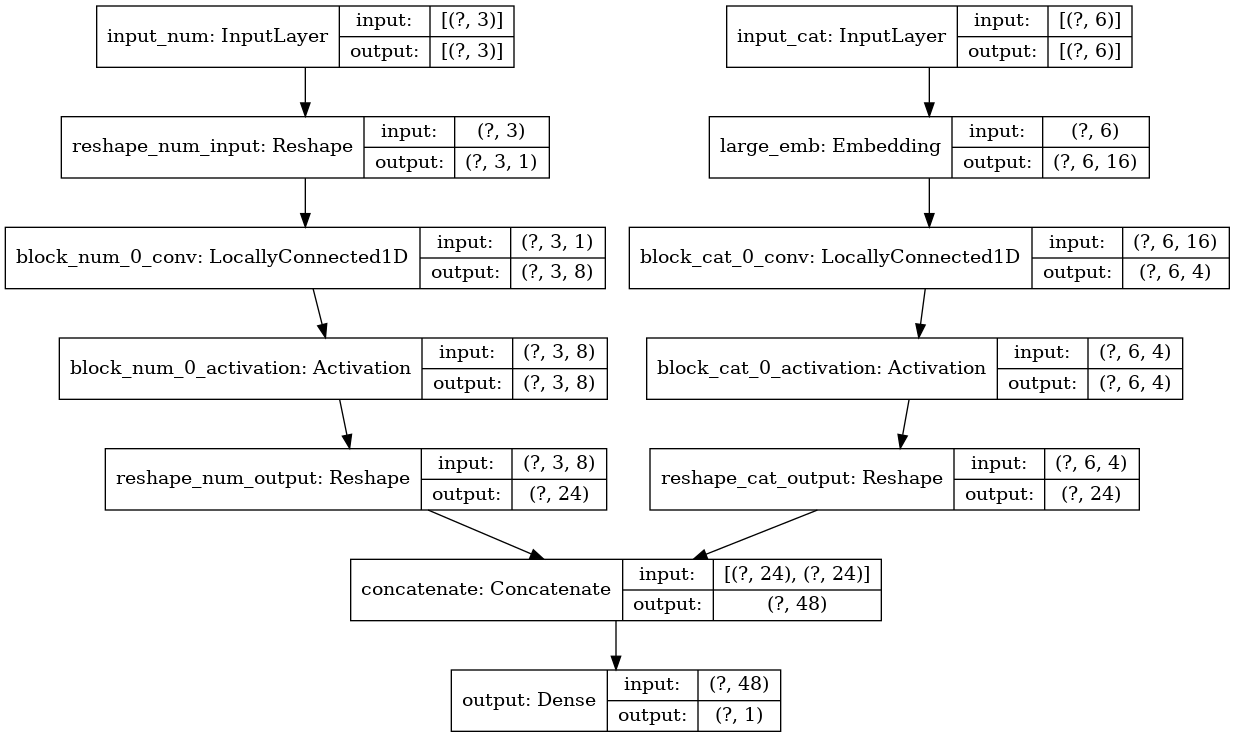

<IPython.core.display.Javascript object>

In [22]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [23]:
y_train.shape

(120000,)

<IPython.core.display.Javascript object>

In [24]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [25]:
class_weight = {
    0: counts[0],
    1: counts[1],
}
class_weight

{0: 1.0713520462824084, 1: 15.015015015015015}

<IPython.core.display.Javascript object>

In [26]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
    class_weight=class_weight
)

Epoch 1/2000
118/118 - 0s - loss: 1.3878 - val_loss: 0.6901
Epoch 2/2000
118/118 - 0s - loss: 1.3831 - val_loss: 0.6825
Epoch 3/2000
118/118 - 0s - loss: 1.3711 - val_loss: 0.6602
Epoch 4/2000
118/118 - 0s - loss: 1.3387 - val_loss: 0.6065
Epoch 5/2000
118/118 - 0s - loss: 1.2758 - val_loss: 0.5446
Epoch 6/2000
118/118 - 0s - loss: 1.2033 - val_loss: 0.5243
Epoch 7/2000
118/118 - 0s - loss: 1.1488 - val_loss: 0.5296
Epoch 8/2000
118/118 - 0s - loss: 1.1223 - val_loss: 0.5357
Epoch 9/2000
118/118 - 0s - loss: 1.1118 - val_loss: 0.5359
Epoch 10/2000
118/118 - 0s - loss: 1.1065 - val_loss: 0.5453
Epoch 11/2000
118/118 - 0s - loss: 1.1027 - val_loss: 0.5409
Epoch 12/2000
118/118 - 0s - loss: 1.0995 - val_loss: 0.5342
Epoch 13/2000
118/118 - 0s - loss: 1.0966 - val_loss: 0.5348
Epoch 14/2000
118/118 - 0s - loss: 1.0937 - val_loss: 0.5362
Epoch 15/2000
118/118 - 0s - loss: 1.0911 - val_loss: 0.5296
Epoch 16/2000
118/118 - 0s - loss: 1.0886 - val_loss: 0.5318
Epoch 17/2000
118/118 - 0s - loss

<IPython.core.display.Javascript object>

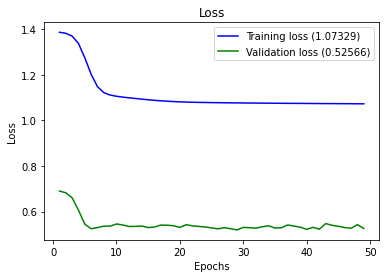

<IPython.core.display.Javascript object>

In [27]:
plot_history(history)

In [28]:
model_auc = roc_auc_score(
    y_true=y_valid,
    y_score=model.predict(input_valid).reshape(-1),
)
model_auc

0.7968204138856548

<IPython.core.display.Javascript object>

In [29]:
model_auc = roc_auc_score(
    y_true=y_test,
    y_score=model.predict(input_test).reshape(-1),
)
model_auc

0.8139579554698695

<IPython.core.display.Javascript object>

In [30]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [31]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [32]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [33]:
y_test.shape

(15000,)

<IPython.core.display.Javascript object>

In [34]:
encoded_output.shape

(15000, 48)

<IPython.core.display.Javascript object>

In [35]:
explanations.shape

(15000, 9)

<IPython.core.display.Javascript object>

In [36]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [37]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['MonthlyIncome', 'DebtRatio',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfDependents',
       'NumberRealEstateLoansOrLines',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfTime60-89DaysPastDueNotWorse'], dtype='<U36')

<IPython.core.display.Javascript object>

## Explain global

In [38]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [39]:
global_explain = np.sum(explanations_train, axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

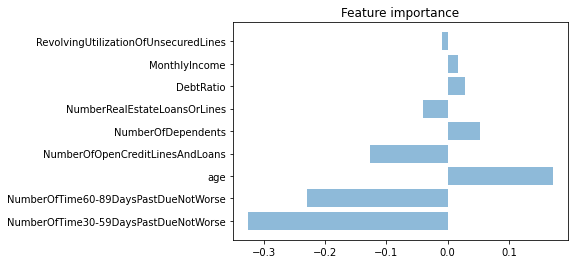

<IPython.core.display.Javascript object>

In [40]:
explain_plot(global_explain, all_cols)

In [41]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / global_explain.sum()

<IPython.core.display.Javascript object>

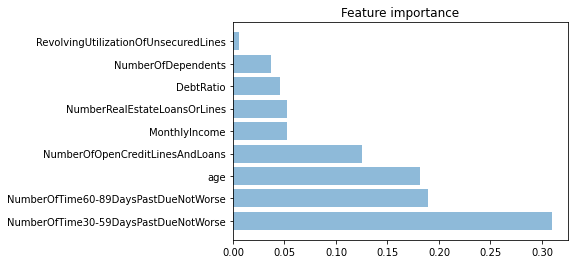

<IPython.core.display.Javascript object>

In [42]:
explain_plot(global_explain, all_cols)

## Explain local

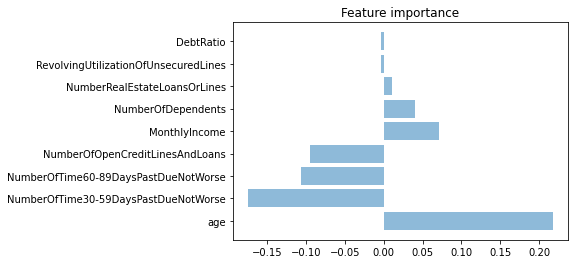

0.4999704957008362


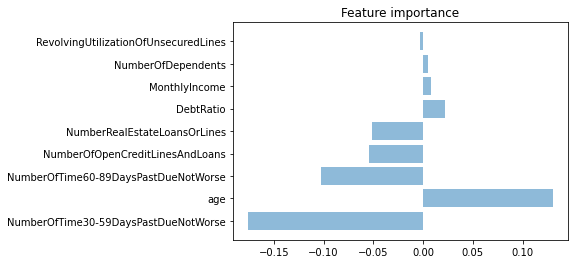

0.33983051776885986


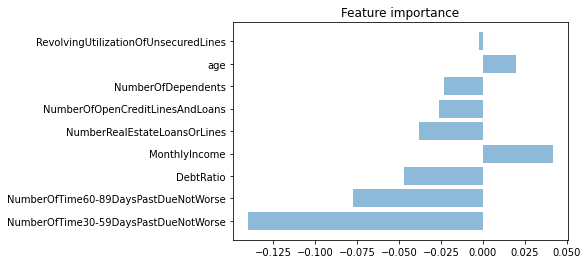

0.19742095470428467


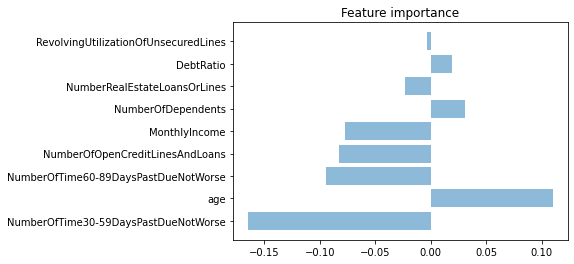

0.2747994661331177


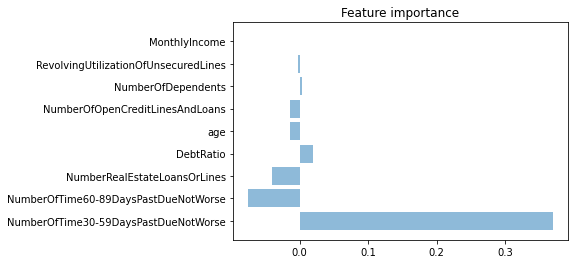

0.7374737858772278


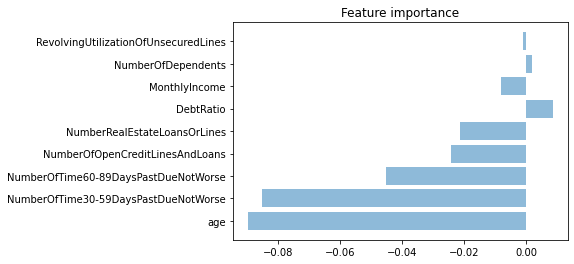

0.09773465991020203


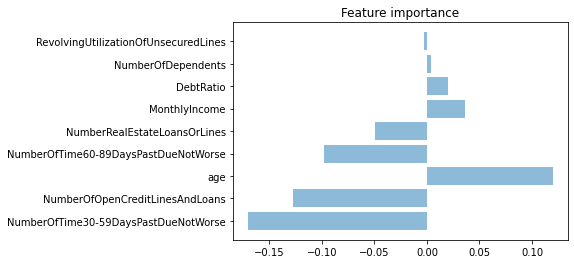

0.30170148611068726


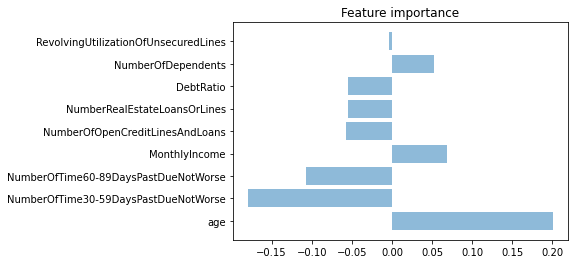

0.4319436252117157


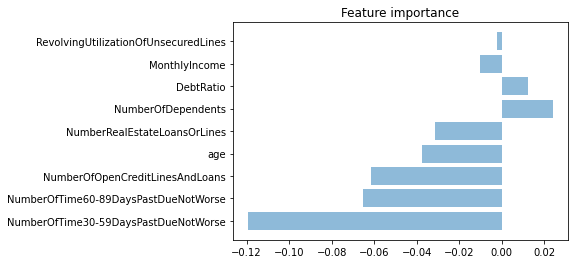

0.15357911586761475


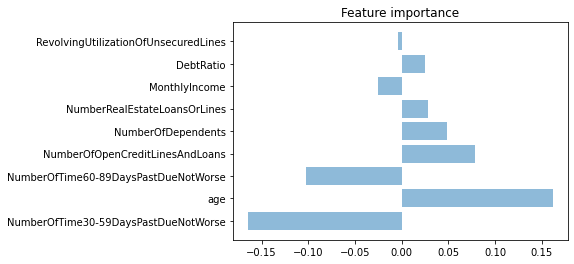

0.5613541007041931


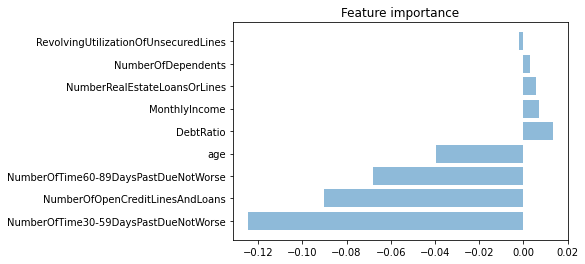

0.1638333797454834


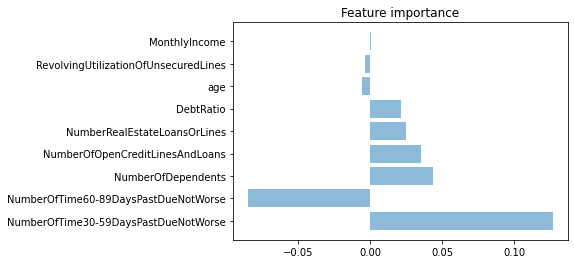

0.6880401372909546


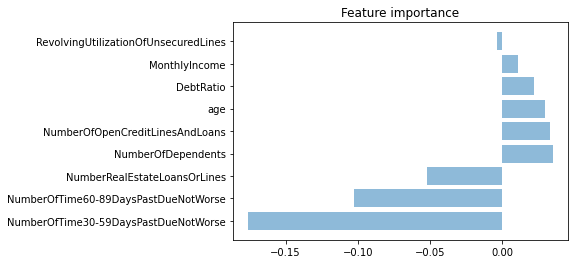

0.3417634665966034


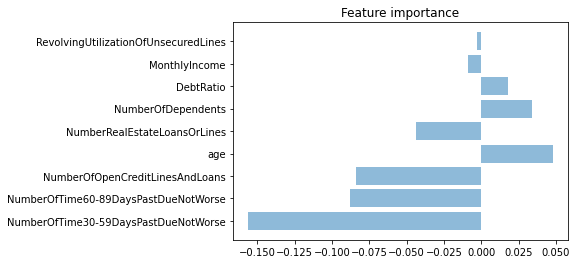

0.2433103322982788


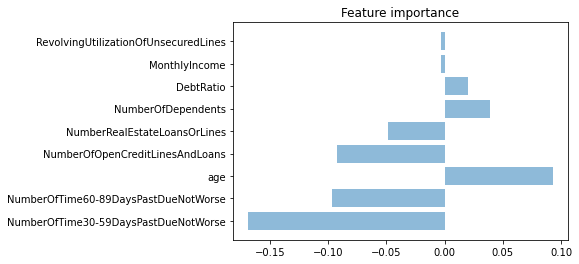

0.2935004234313965


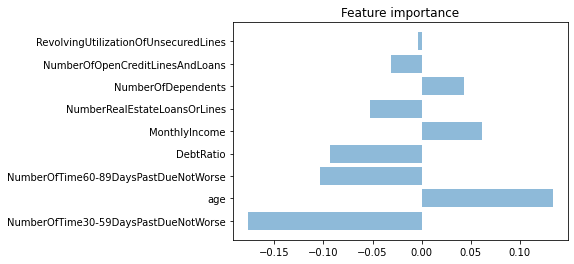

0.3485841751098633


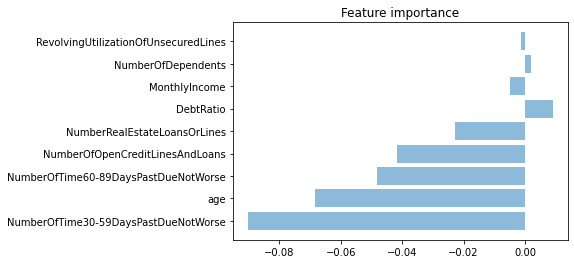

0.10491091012954712


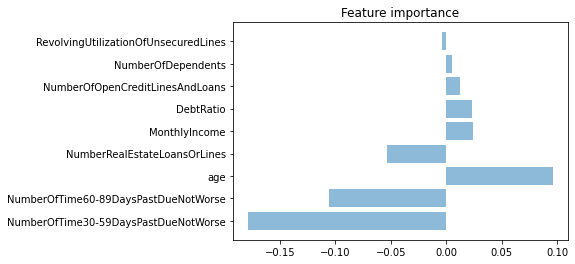

0.37090131640434265


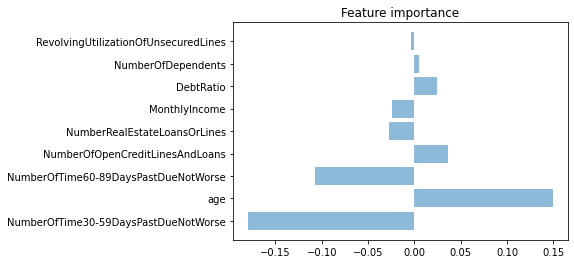

0.4247702360153198


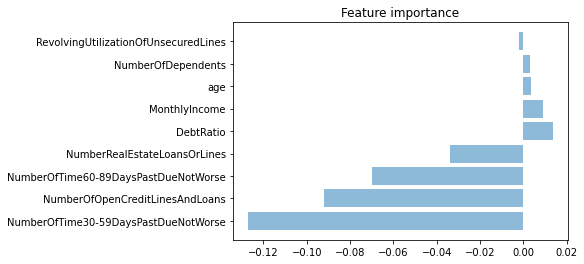

0.16900208592414856


<IPython.core.display.Javascript object>

In [43]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [44]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [45]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([13947,  1053]))

<IPython.core.display.Javascript object>

In [46]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [47]:
target_encoder.classes_

array([0, 1])

<IPython.core.display.Javascript object>

In [48]:
confusion_matrix(
    y_true=y_test,
    y_pred=model.predict(input_test).reshape(-1) >= 0.5,
    # labels=target_encoder.classes_,
)

array([[11442,  2505],
       [  353,   700]])

<IPython.core.display.Javascript object>